# Mercari Price Suggestion Challenge GBM Classifier

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pdb
import re
import pickle
import string
import pandas as pd
import numpy as np
import lightgbm as lgb
np.set_printoptions(precision=4)

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from pathlib import Path

from utils.data_utils import set_two_splits
from utils.plots import *

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

In [3]:
from args import args
vars(args)

{'path': PosixPath('data'),
 'workdir': PosixPath('data/workdir'),
 'train_tsv': PosixPath('data/train.tsv'),
 'test_tsv': PosixPath('data/test.tsv'),
 'test2_tsv': PosixPath('data/test_stg2.tsv'),
 'modeldir': PosixPath('data/workdir/models'),
 'figdir': PosixPath('data/workdir/figures')}

In [14]:
save = True

## Functions

In [5]:
def wordcloud(fi, idx2tok, min_len=5, n_tokens=50):
  idxs = np.argsort(fi)[-n_tokens:]
  score = fi[idxs]/fi[idxs].sum()
  tokens = [idx2tok[i] for i in idxs]
  d = dict(zip(tokens, score))
  return d, WordCloud(width=400, height=400, background_color='white', max_words=n_tokens, max_font_size=40, relative_scaling=0.5).generate_from_frequencies(d)

## Train and Validation

In [6]:
desc_df = pd.read_csv(args.path/'train_df.csv', usecols=['text', 'price'])
desc_df.head()

,price,text
0,2.397895,MLB Cincinnati Reds T Shirt Size XL\n
1,3.970292,Razer BlackWidow Chroma Keyboard\nThis keyboar...
2,2.397895,AVA-VIV Blouse\nAdorable top with a hint of la...
3,3.583519,Leather Horse Statues\nNew with tags. Leather ...
4,3.806662,24K GOLD plated rose\nComplete with certificat...


In [7]:
seed = 643
df = set_two_splits(desc_df.copy(), 'valid', seed=seed)
train_df = df.loc[df['split'] == 'train', ['text', 'price']]
valid_df = df.loc[df['split'] == 'valid', ['text', 'price']]
y_train = train_df['price']
y_valid = valid_df['price']

df.shape, train_df.shape, valid_df.shape, y_train.shape, y_valid.shape

((1462949, 3), (1243506, 2), (219443, 2), (1243506,), (219443,))

In [8]:
# vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=60_000)
# x_train = vectorizer.fit_transform(train_df['text'].values.astype('U'))
# x_valid = vectorizer.transform(valid_df['text'].values.astype('U'))

# with open(args.workdir/'bigram_643.pkl', 'wb') as f:
#   pickle.dump(vectorizer, f)
#   pickle.dump(x_train, f)
#   pickle.dump(x_valid, f)

In [9]:
with open(args.workdir/'bigram_643.pkl', 'rb') as f:
  vectorizer = pickle.load(f)
  x_train = pickle.load(f)
  x_valid = pickle.load(f)
  
idx2tok = {v: k for k, v in vectorizer.vocabulary_.items()}  

In [10]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

lgb_params = {
  'num_leaves': 400,
  'learning_rate': 0.05,
  'feature_fraction': 0.9,
  'bagging_fraction': 0.7,
  'bagging_freq': 5,
  'metric': 'rmse',
  'num_threads': 32,
  'max_bin': 32,
  'objective': 'regression',
}

In [11]:
gbm = lgb.train(lgb_params, lgb_train, num_boost_round=600, valid_sets=[lgb_train, lgb_valid], early_stopping_rounds=10)

[1]	training's rmse: 0.718157	valid_1's rmse: 0.717244
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 0.708547	valid_1's rmse: 0.70771
[3]	training's rmse: 0.700389	valid_1's rmse: 0.699635
[4]	training's rmse: 0.69224	valid_1's rmse: 0.691594
[5]	training's rmse: 0.684643	valid_1's rmse: 0.684045
[6]	training's rmse: 0.677265	valid_1's rmse: 0.676718
[7]	training's rmse: 0.670734	valid_1's rmse: 0.670214
[8]	training's rmse: 0.664662	valid_1's rmse: 0.664227
[9]	training's rmse: 0.658975	valid_1's rmse: 0.658647
[10]	training's rmse: 0.653228	valid_1's rmse: 0.652935
[11]	training's rmse: 0.648435	valid_1's rmse: 0.648249
[12]	training's rmse: 0.643868	valid_1's rmse: 0.643793
[13]	training's rmse: 0.639649	valid_1's rmse: 0.639681
[14]	training's rmse: 0.635673	valid_1's rmse: 0.635799
[15]	training's rmse: 0.631473	valid_1's rmse: 0.631696
[16]	training's rmse: 0.627979	valid_1's rmse: 0.628304
[17]	training's rmse: 0.623804	valid_1's rmse: 0.62420

[147]	training's rmse: 0.493712	valid_1's rmse: 0.505496
[148]	training's rmse: 0.493362	valid_1's rmse: 0.505231
[149]	training's rmse: 0.493017	valid_1's rmse: 0.504954
[150]	training's rmse: 0.492698	valid_1's rmse: 0.504716
[151]	training's rmse: 0.492347	valid_1's rmse: 0.504435
[152]	training's rmse: 0.492009	valid_1's rmse: 0.504177
[153]	training's rmse: 0.491681	valid_1's rmse: 0.503936
[154]	training's rmse: 0.491363	valid_1's rmse: 0.503693
[155]	training's rmse: 0.491049	valid_1's rmse: 0.503449
[156]	training's rmse: 0.490714	valid_1's rmse: 0.503184
[157]	training's rmse: 0.490413	valid_1's rmse: 0.502968
[158]	training's rmse: 0.490099	valid_1's rmse: 0.502723
[159]	training's rmse: 0.489786	valid_1's rmse: 0.502482
[160]	training's rmse: 0.48946	valid_1's rmse: 0.502226
[161]	training's rmse: 0.48914	valid_1's rmse: 0.501978
[162]	training's rmse: 0.488839	valid_1's rmse: 0.501745
[163]	training's rmse: 0.488534	valid_1's rmse: 0.50151
[164]	training's rmse: 0.488224	va

[292]	training's rmse: 0.461501	valid_1's rmse: 0.483391
[293]	training's rmse: 0.46134	valid_1's rmse: 0.483298
[294]	training's rmse: 0.461177	valid_1's rmse: 0.483199
[295]	training's rmse: 0.461027	valid_1's rmse: 0.483128
[296]	training's rmse: 0.460867	valid_1's rmse: 0.483043
[297]	training's rmse: 0.460714	valid_1's rmse: 0.48295
[298]	training's rmse: 0.460568	valid_1's rmse: 0.482882
[299]	training's rmse: 0.460416	valid_1's rmse: 0.482787
[300]	training's rmse: 0.460268	valid_1's rmse: 0.48271
[301]	training's rmse: 0.460127	valid_1's rmse: 0.482623
[302]	training's rmse: 0.459972	valid_1's rmse: 0.482538
[303]	training's rmse: 0.459819	valid_1's rmse: 0.482451
[304]	training's rmse: 0.459688	valid_1's rmse: 0.482368
[305]	training's rmse: 0.459552	valid_1's rmse: 0.48228
[306]	training's rmse: 0.459389	valid_1's rmse: 0.482192
[307]	training's rmse: 0.459228	valid_1's rmse: 0.482101
[308]	training's rmse: 0.459095	valid_1's rmse: 0.482024
[309]	training's rmse: 0.458953	val

[437]	training's rmse: 0.44387	valid_1's rmse: 0.474449
[438]	training's rmse: 0.44377	valid_1's rmse: 0.474411
[439]	training's rmse: 0.443668	valid_1's rmse: 0.474355
[440]	training's rmse: 0.443567	valid_1's rmse: 0.474318
[441]	training's rmse: 0.443467	valid_1's rmse: 0.474278
[442]	training's rmse: 0.443358	valid_1's rmse: 0.474229
[443]	training's rmse: 0.443264	valid_1's rmse: 0.474195
[444]	training's rmse: 0.443164	valid_1's rmse: 0.474154
[445]	training's rmse: 0.443081	valid_1's rmse: 0.474126
[446]	training's rmse: 0.442974	valid_1's rmse: 0.474064
[447]	training's rmse: 0.442878	valid_1's rmse: 0.474015
[448]	training's rmse: 0.442787	valid_1's rmse: 0.473977
[449]	training's rmse: 0.442696	valid_1's rmse: 0.473938
[450]	training's rmse: 0.442596	valid_1's rmse: 0.473897
[451]	training's rmse: 0.442486	valid_1's rmse: 0.473845
[452]	training's rmse: 0.442375	valid_1's rmse: 0.473798
[453]	training's rmse: 0.442278	valid_1's rmse: 0.473748
[454]	training's rmse: 0.442188	v

[582]	training's rmse: 0.431158	valid_1's rmse: 0.469502
[583]	training's rmse: 0.431092	valid_1's rmse: 0.469478
[584]	training's rmse: 0.431026	valid_1's rmse: 0.469452
[585]	training's rmse: 0.430951	valid_1's rmse: 0.469427
[586]	training's rmse: 0.430877	valid_1's rmse: 0.469406
[587]	training's rmse: 0.430802	valid_1's rmse: 0.469382
[588]	training's rmse: 0.430717	valid_1's rmse: 0.469343
[589]	training's rmse: 0.430642	valid_1's rmse: 0.469324
[590]	training's rmse: 0.430569	valid_1's rmse: 0.469306
[591]	training's rmse: 0.43049	valid_1's rmse: 0.469276
[592]	training's rmse: 0.430409	valid_1's rmse: 0.469253
[593]	training's rmse: 0.43034	valid_1's rmse: 0.469236
[594]	training's rmse: 0.43027	valid_1's rmse: 0.469214
[595]	training's rmse: 0.430204	valid_1's rmse: 0.469202
[596]	training's rmse: 0.430132	valid_1's rmse: 0.469168
[597]	training's rmse: 0.430059	valid_1's rmse: 0.469137
[598]	training's rmse: 0.429983	valid_1's rmse: 0.469118
[599]	training's rmse: 0.4299	vali

(-0.5, 399.5, 399.5, -0.5)

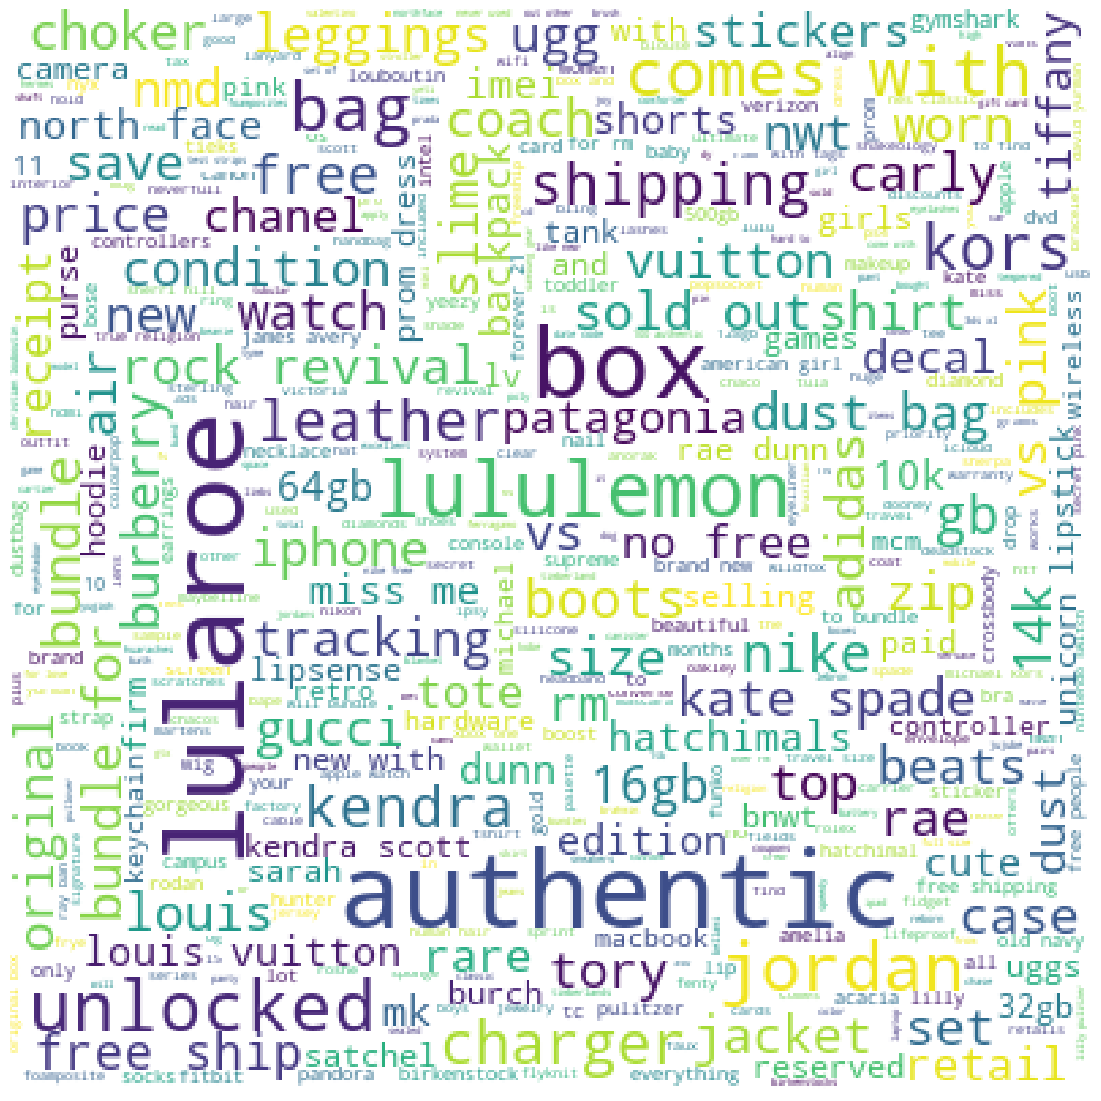

In [12]:
fig, ax = plt.subplots(figsize=(20, 20))
d, wc = wordcloud(gbm.feature_importance(importance_type='gain'), idx2tok, min_len=5, n_tokens=500)
ax.imshow(wc)
ax.axis('off')

if save:
  fig.savefig(args.figdir/'desc_wc.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [16]:
preds = gbm.predict(x_valid)
np.round(np.sqrt(mean_squared_error(y_valid, preds)), 3)

0.469

## Full Model Training

In [ ]:
train_df = pd.read_csv(args.path/'train_df.csv', usecols=['text', 'price'])
train_df.shape

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=60_000)
x_train = vectorizer.fit_transform(train_df['text'].values.astype('U'))

with open(args.vectordir/'default_bi_all.pkl', 'wb') as f:
  pickle.dump(vectorizer, f)
  pickle.dump(x_train, f)
  
y_train = train_df['price']
x_train.shape, y_train.shape

In [ ]:
with open(args.vectordir/'default_bi_all.pkl', 'rb') as f:
  vectorizer = pickle.load(f)
  x_train = pickle.load(f)

idx2tok = {v: k for k, v in vectorizer.vocabulary_.items()}

In [ ]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_params = {
  'num_leaves': 400,
  'learning_rate': 0.05,
  'feature_fraction': 0.9,
  'bagging_fraction': 0.7,
  'bagging_freq': 5,
  'metric': 'rmse',
  'num_threads': 32,
  'max_bin': 32,
  'objective': 'regression',
}

In [ ]:
gbm = lgb.train(lgb_params, lgb_train, num_boost_round=1000, valid_sets=[lgb_train], early_stopping_rounds=10, verbose_eval=True)
pickle.dump(gbm, (args.modeldir/'gbm_desc_all.pkl').open('wb'))

## Word Cloud

In [ ]:
gbm = pickle.load((args.modeldir/'gbm_desc_all.pkl').open('rb'))

with open(args.vectordir/'default_bi_all.pkl', 'rb') as f:
  vectorizer = pickle.load(f)
  x_train = pickle.load(f)

idx2tok = {v: k for k, v in vectorizer.vocabulary_.items()}

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
d, wc = wordcloud(gbm.feature_importance(importance_type='gain'), idx2tok, min_len=5, n_tokens=500)
ax.imshow(wc)
ax.axis('off')
fig.savefig(args.figdir/'gbm_desc_wc.pdf', dpi=300)

In [ ]:
test_df = pd.read_csv(args.path/'test_df.csv', usecols=['test_id', 'text'])
x_test = vectorizer.transform(test_df['text'].values.astype('U'))
preds = pd.DataFrame({'test_id': test_df['test_id'], 'price': np.expm1(gbm.predict(x_test))})
preds.to_csv(args.path/'gbm_desc_submission.csv', index=False)

In [ ]:
test2_df = pd.read_csv(args.path/'test2_df.csv', usecols=['test_id', 'text'])
x_test2 = vectorizer.transform(test2_df['text'].values.astype('U'))
preds_test2 = pd.DataFrame({'test_id': test2_df['test_id'], 'price': np.expm1(gbm.predict(x_test2))})
preds_test2.to_csv(args.path/'gbm_desc_submission_stg2.csv', index=False)